In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, mean_squared_error, r2_score

In [17]:
#soft labels calculated based on 857 samples
annotated_df = pd.read_csv('data/softlabels_per_Subtype.csv', sep=',', index_col=0)
#AUC of 0.934


In [8]:
#Calculates Soft Probabilities for HRD from 9600 samples instead of filtering to 857 and then calcualting soft probabilities.
hrd_df = pd.read_csv('data/tot_hrd_soft_labels.csv', sep=',', index_col=0)
hrd_df.set_index('sample', inplace=True)
hrd_df

annotated_df = pd.read_csv('data/softlabels_per_Subtype.csv', sep=',', index_col=0)
annotated_df.drop(columns=['soft prob'], inplace=True)
annotated_df



annotated_df['soft prob'] = hrd_df['soft prob']
annotated_df


#AUC of 0.869

,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC,HRD_status_base,HRD_adjust,soft prob
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,NaN,0,HR,HRP,0.00000
TCGA-A1-A0SD,10,10,7,27,0,0,0.0,0,0,0,...,0,0,0,0,0,LumA,0,HR,HRP ambiguous,0.51125
TCGA-A1-A0SE,6,6,1,13,0,0,0.0,0,0,0,...,0,0,0,0,0,LumA,0,HR,HRP ambiguous,0.13875
TCGA-A1-A0SF,7,11,8,26,0,0,0.0,0,0,0,...,0,0,0,0,0,LumA,0,HR,HRP ambiguous,0.52000
TCGA-A1-A0SG,3,2,4,9,0,0,0.0,0,0,0,...,0,0,0,0,0,LumA,0,HR,HRP,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-OL-A6VR,4,4,5,13,0,0,0.0,NaN,0,0,...,0,0,0,0,0,LumA,0,HR,HRP ambiguous,0.13875
TCGA-PE-A5DC,13,20,16,49,0,0,0.0,0,NaN,0,...,0,Bi-allelic-inactivation,0,0,YES,LumA,0,HRD,HRD ambiguous,0.95125
TCGA-PE-A5DD,7,6,9,22,0,0,0.0,0,NaN,0,...,0,0,0,0,0,LumA,0,HR,HRP ambiguous,0.58000


In [18]:
rnaseq_df = pd.read_csv('data/Deconvo2.csv', sep=',', index_col=0).reset_index(names="Case ID")
rnaseq_df['Case ID'] = rnaseq_df['Case ID'].str.split('-').str[:3].str.join('-')
rnaseq_df['Sample ID'] = rnaseq_df['Case ID'].str.split('-').str[:4].str.join('-')
# rnaseq_df = pd.read_csv('data/tcga.brca.rnaseq.unstranded.raw.counts.matrix-2.txt', sep= '\t', index_col=0)
# rnaseq_df

In [19]:

brca_df_filtered = annotated_df[
    (annotated_df['event.BRCA1'] != '1') &
    (annotated_df['event.BRCA2'] != 'Bi-allelic-undetermined') &
    (annotated_df['event.PALB2'] != '2')
]

# Identify common samples across the dataframes
common_samples = set(rnaseq_df['Case ID']).intersection(set(brca_df_filtered.index))

# Filter RNA-seq dataframe for common samples
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]

# Filter BRCA dataframe for common samples
brca_df_common = brca_df_filtered[brca_df_filtered.index.isin(common_samples)]

# Drop duplicates in rnaseq_df_common if any
rnaseq_df_common = rnaseq_df_common.drop_duplicates(subset=['Case ID'])

rnaseq_df_common.set_index('Case ID', inplace=True)

# Sort the samples in both dataframes by index
rnaseq_df_common = rnaseq_df_common.sort_index()
brca_df_common = brca_df_common.sort_index()


In [20]:
genes_validation = pd.read_csv('data/validation/CCLE_RNAseq_genes_counts_20180929.gct', sep="\t", skiprows=2)
# Drop the 'Ensembl IDs' column
genes_validation_transposed = genes_validation.drop(columns=['Name'])

# Set the 'Description' column as the new header (column names)
genes_validation_transposed = genes_validation_transposed.set_index('Description').transpose()

# genes_validation_transposed_sorted = genes_validation_transposed.sort_index(axis = 1)
# Drop columns that have only zeros
genes_validation_transposed = genes_validation_transposed.loc[:, ~(genes_validation_transposed == 0).all()]

# drop duplicates
genes_validation_transposed_sorted = genes_validation_transposed.loc[:, ~genes_validation_transposed.columns.duplicated()]

In [21]:
deseq_results=pd.read_csv('data/basic_deseq_HRD_contrast.csv', index_col=0)
deseq_filtered_rna_seq_df = rnaseq_df_common[rnaseq_df_common.columns.intersection(deseq_results.index)]

# Step 1: Find common columns
common_columns = set(deseq_filtered_rna_seq_df.columns).intersection(genes_validation_transposed.columns)

# Step 2: Filter each dataframe to keep only common columns
deseq_filtered_rna_seq_df_common = deseq_filtered_rna_seq_df[list(common_columns)]
genes_validation_common = genes_validation_transposed_sorted[list(common_columns)]

# Display the resulting shapes to confirm
print("Shape of filtered deseq_filtered_rna_seq_df:", deseq_filtered_rna_seq_df_common.shape)
print("Shape of filtered genes_validation:", genes_validation_common.shape)

breast_filt = genes_validation_common[genes_validation_common.index.str.contains('BREAST')]

Shape of filtered deseq_filtered_rna_seq_df: (857, 6347)
Shape of filtered genes_validation: (1019, 6347)



Training Elastic Net with Grid Search to predict HRD probabilities:


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.585e-01, tolerance: 8.601e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.210e-02, tolerance: 8.601e-03
  model = cd_fast.enet_coordinate_descent(


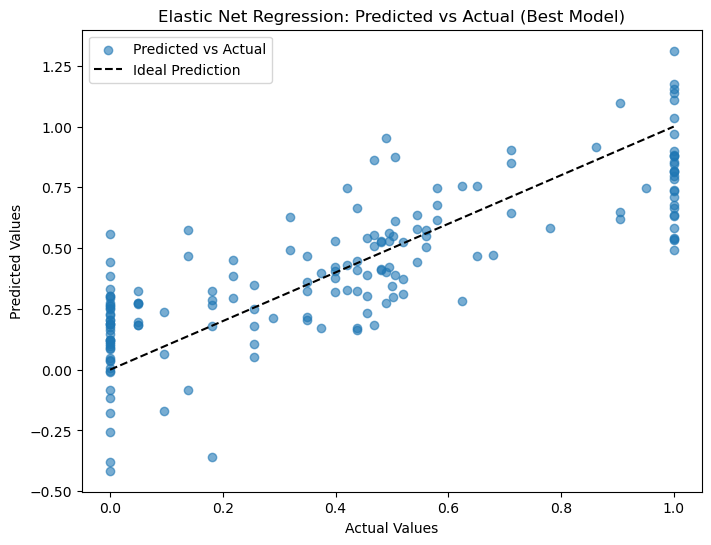

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Mean Squared Error: 0.046
R^2 Score: 0.639


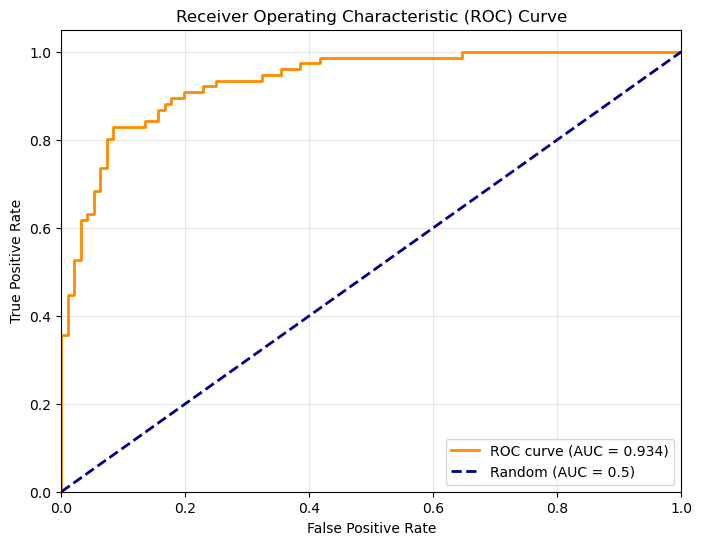


Model Performance Metrics:
AUC Score: 0.934
Threshold used: 0.46875
Positive rate in test set: 0.442

Prediction Statistics:
Mean: 0.423
Std: 0.314
Range: [-0.416, 1.312]

Final Metrics: {'Mean Squared Error': 0.04573557889817473, 'R^2 Score': 0.6387708523157476, 'AUC': 0.9336622807017544, 'Threshold': 0.46875}
Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.5}


In [22]:
from sklearn.model_selection import ParameterGrid
def preprocess_data(X, y, task='regression'):
    """
    Preprocesses data by splitting into train-test sets and scaling features.
    For regression, no label encoding is applied.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test
# Elastic Net Training & Evaluation with Grid Search
def train_evaluate_elastic_net_with_grid_search(X_train, X_test, y_train, y_test, alphas, l1_ratios):
    """
    Trains and evaluates Elastic Net models for a grid of hyperparameters.
    Returns the best model and its metrics.
    """
    best_model = None
    best_metrics = {'Mean Squared Error': float('inf'), 'R^2 Score': -float('inf')}
    best_params = {}

    # Grid search
    param_grid = ParameterGrid({'alpha': alphas, 'l1_ratio': l1_ratios})
    for params in param_grid:
        model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Update best model if current is better
        if mse < best_metrics['Mean Squared Error']:
            best_model = model
            best_metrics = {'Mean Squared Error': mse, 'R^2 Score': r2}
            best_params = params

    # Scatter plot of predictions vs actual values for the best model
    y_pred_best = best_model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.6, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Regression: Predicted vs Actual (Best Model)')
    plt.legend(loc="upper left")
    plt.show()
    
    print(f"Best Parameters: {best_params}")
    print(f"Mean Squared Error: {best_metrics['Mean Squared Error']:.3f}")
    print(f"R^2 Score: {best_metrics['R^2 Score']:.3f}")
    
    return best_model, best_metrics, best_params

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_auc(model, X_test, y_test, threshold=0.5):
    # Get probability predictions
    y_pred_proba = model.predict(X_test)
    
    # Convert continuous y_test to binary using the same threshold
    y_test_binary = (y_test >= threshold).astype(int)
    
    # Calculate ROC curve and AUC using binary ground truth
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate distribution of predictions
    pred_stats = {
        'mean': np.mean(y_pred_proba),
        'std': np.std(y_pred_proba),
        'min': np.min(y_pred_proba),
        'max': np.max(y_pred_proba)
    }
    
    # Calculate additional metrics
    metrics = {
        'AUC': roc_auc,
        'Threshold': threshold,
        'Predictions Shape': y_pred_proba.shape,
        'True Labels Shape': y_test.shape,
        'Prediction Stats': pred_stats,
        'Positive Rate': np.mean(y_test_binary)  # Proportion of positive cases
    }
    
    # Print metrics
    print("\nModel Performance Metrics:")
    print(f"AUC Score: {metrics['AUC']:.3f}")
    print(f"Threshold used: {metrics['Threshold']}")
    print(f"Positive rate in test set: {metrics['Positive Rate']:.3f}")
    print("\nPrediction Statistics:")
    print(f"Mean: {pred_stats['mean']:.3f}")
    print(f"Std: {pred_stats['std']:.3f}")
    print(f"Range: [{pred_stats['min']:.3f}, {pred_stats['max']:.3f}]")
    
    return metrics

# Modified main function
def main():
    """
    Main function for preprocessing data, training Elastic Net with grid search, and displaying results.
    """
    print("\nTraining Elastic Net with Grid Search to predict HRD probabilities:")
    # Example data preprocessing
    X_train, X_test, y_train, y_test = preprocess_data(
        deseq_filtered_rna_seq_df_common, 
        brca_df_common['soft prob'], 
        task='regression'
    )
    
    # Define hyperparameter ranges
    alphas = [0.01, 0.1, 0.25, 0.5, 1.0]
    l1_ratios = [0.1, 0.5, 0.7, 0.9]
    
    # Train and evaluate model
    best_model, best_metrics, best_params = train_evaluate_elastic_net_with_grid_search(
        X_train, X_test, y_train, y_test, alphas, l1_ratios
    )
    
    # Calculate and plot AUC using the median of y_train as threshold
    threshold = np.median(y_train)  # Using median as threshold
    auc_metrics = calculate_and_plot_auc(best_model, X_test, y_test, threshold=threshold)
    
    # Update metrics dictionary with AUC
    best_metrics.update({'AUC': auc_metrics['AUC']})
    best_metrics.update({'Threshold': threshold})
    
    return best_model, best_metrics, best_params


elastic_net_model, elastic_net_metrics, elastic_net_params = main()
print("\nFinal Metrics:", elastic_net_metrics)
print("Best Parameters:", elastic_net_params)

In [23]:
breast_filt = breast_filt.clip(lower=1e-6)

# Apply log2 transformation
breast_filt = np.log2(breast_filt)
breast_filt.index = breast_filt.index.str.split('_').str[0]
# Align breast_filt with deseq_filtered_rna_seq_df_common columns
breast_filt_aligned = breast_filt.reindex(columns=deseq_filtered_rna_seq_df_common.columns, fill_value=0)

# Check for column alignment
print("Are columns aligned?", list(breast_filt_aligned.columns) == list(deseq_filtered_rna_seq_df_common.columns))

feature_columns = breast_filt_aligned.columns  # Adjust if necessary
X = breast_filt_aligned[feature_columns]

# Generate predictions
predictions = elastic_net_model.predict(X)

# Add the predictions to the DataFrame
breast_filt_aligned['Predictions'] = predictions
predictions

Are columns aligned? True


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


array([ 0.7378625 ,  0.78771567,  0.12485885,  0.47882304,  0.96595912,
        0.84349561,  0.2260218 ,  0.01202383,  1.02420334,  0.29583909,
       -0.66863521,  0.33012657,  0.06288248,  0.69049456,  0.38480383,
        1.26144799, -0.30918731,  0.39925372,  1.03273833,  0.47907283,
        0.62485388,  0.7797072 ,  0.76725064,  0.74831631,  0.07295355,
        0.27567374,  0.07149923,  1.56050079,  1.39492963,  0.36376752,
       -0.11125769,  0.18020712,  0.83345797,  0.17938663,  1.10845232,
        0.80540509,  0.03661078,  0.78646624,  0.25122825,  0.93650024,
        0.87366252,  0.55092315,  1.10914267, -0.29801976,  1.04731571,
        0.74406278, -0.13497318,  0.12014569,  0.13408995,  0.24675997,
       -0.11065084])

In [24]:
import pandas as pd
import numpy as np

# Load the data
drug_resp = pd.read_csv('data/validation/BRCA_IC_Sat Jan 18 23_56_13 2025.csv')

# Define PARP inhibitors
parps = ['Olaparib', 'Talazoparib', 'Niraparib', 'Rucaparib', 'Veliparib']

# Filter and select specific drugs
parpi_resp = drug_resp[drug_resp['Drug Name'].isin(parps)]
parpi_resp_filt = parpi_resp[['Drug Name', 'Cell Line Name', 'IC50']].copy()

# Apply transformations explicitly
parpi_resp_filt['IC50'] = parpi_resp_filt['IC50'].clip(lower=1e-6)
parpi_resp_filt['log10IC50'] = np.log10(parpi_resp_filt['IC50'])

parpi_resp_filt["Cell Line Name"] = parpi_resp_filt["Cell Line Name"].str.replace("-", "", regex=True)

merged_df = breast_filt_aligned.merge(
    parpi_resp_filt,
    right_on ='Cell Line Name',
    left_index=True
)
subset_df = merged_df[['Cell Line Name', 'Drug Name', 'Predictions', 'log10IC50']]
subset_df

,Cell Line Name,Drug Name,Predictions,log10IC50
31,AU565,Olaparib,0.737863,0.649300
81,AU565,Veliparib,0.737863,0.728449
275,AU565,Rucaparib,0.737863,0.618083
323,AU565,Niraparib,0.737863,0.658753
370,AU565,Talazoparib,0.737863,0.446904
...,...,...,...,...
30,ZR7530,Olaparib,-0.110651,0.774099
80,ZR7530,Veliparib,-0.110651,0.791624
274,ZR7530,Rucaparib,-0.110651,0.785756
322,ZR7530,Niraparib,-0.110651,0.690543


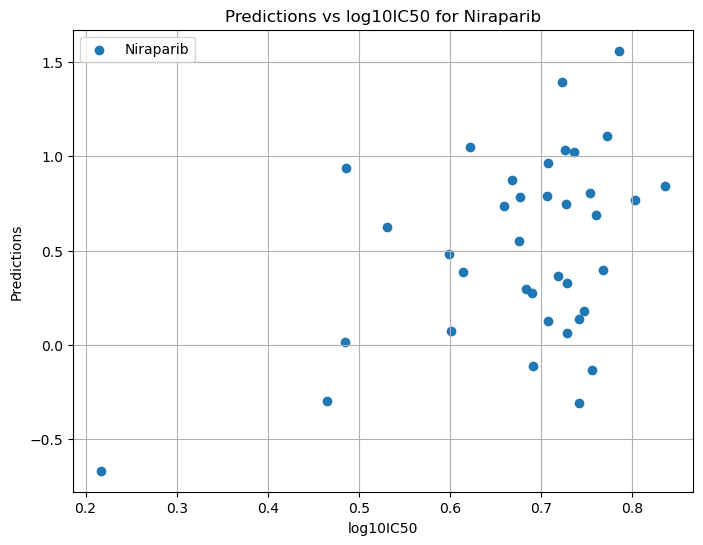

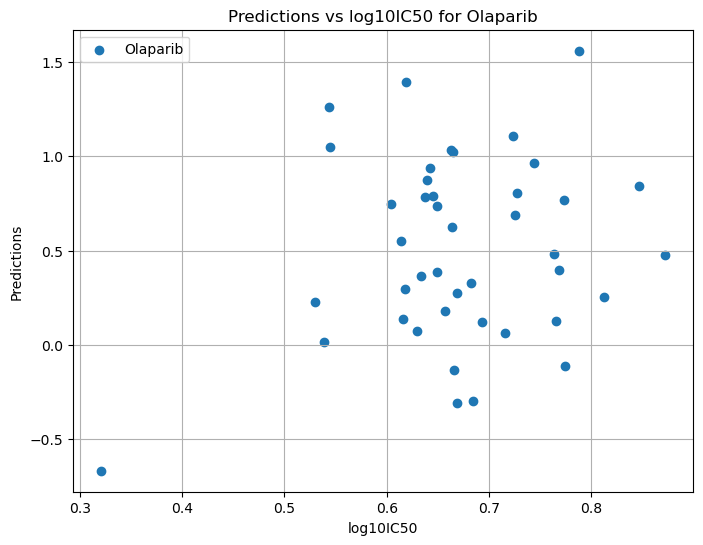

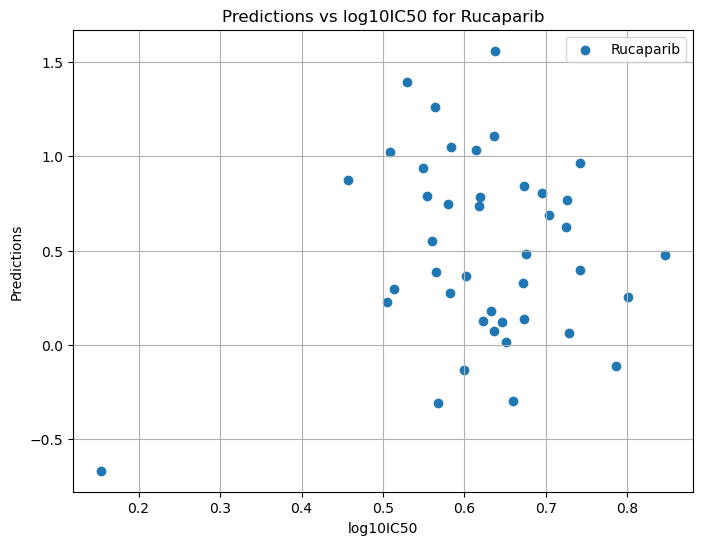

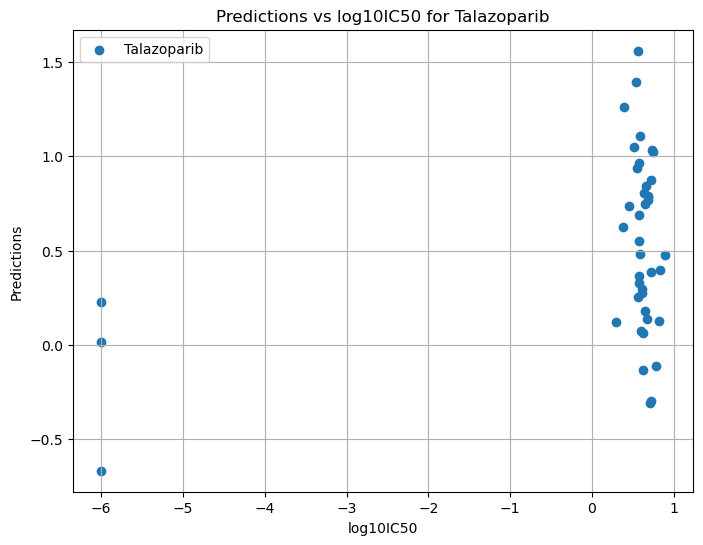

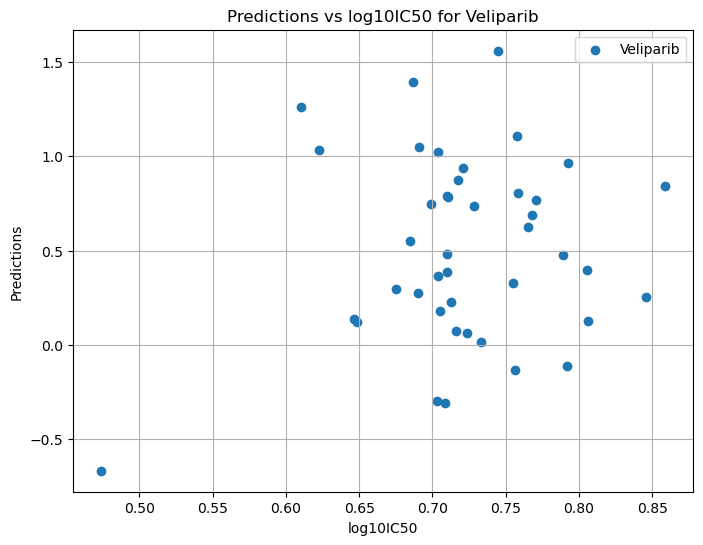

In [25]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'Drug Name'
grouped = merged_df.groupby('Drug Name')

# Loop through each group and create a plot
for drug_name, group in grouped:
    plt.figure(figsize=(8, 6))
    plt.scatter(group['log10IC50'], group['Predictions'], label=drug_name)
    plt.title(f'Predictions vs log10IC50 for {drug_name}')
    plt.xlabel('log10IC50')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.legend()
    plt.show()
